In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from tqdm import tqdm
import os
import matplotlib.pyplot as pl
import cv2

In [29]:
data_dir = "/home/voodo/PGU/mainWork/parNet/AnimalsTest/dts/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")

In [30]:
train_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_train_subdir}
test_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_test_subdir}
# all_image_counts=train_image_counts.copy()
# all_image_counts={k:all_image_counts[k]+test_image_counts[k] for k in all_image_counts.keys()}
train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df.head()

train  test
Lizard                  1200   260
Squirrel                 367    68
Giraffe                  298    23
Brown bear               108    39
Moths and butterflies   1429    29

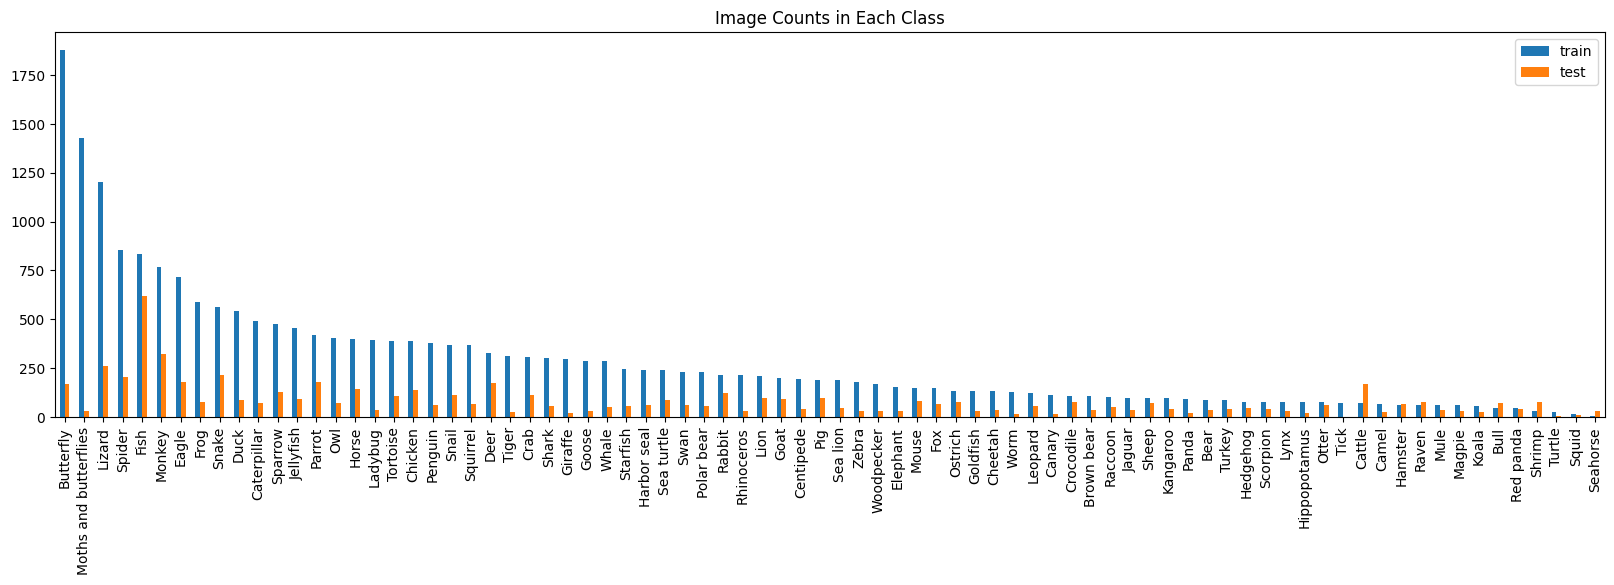

In [31]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");

In [32]:
train_classes=[os.path.basename(pp) for pp in all_train_subdir]
test_classes=[os.path.basename(pp) for pp in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))

train_classes==test_classes

There is 80 classes in train dataset, and 80 classes in test dataset


True

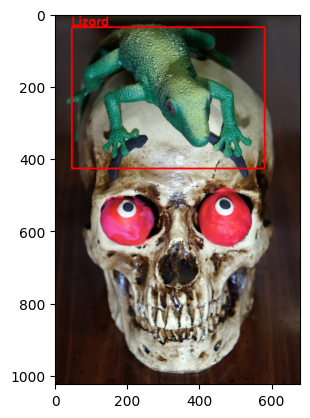

In [39]:
def draw_image(image_file, label_file, class_names):
    class_name = os.path.basename(os.path.dirname(image_file))
    image = cv2.imread(image_file)

    with open(label_file) as fobj:
        while True:
            item = fobj.readline()
            if item is None or len(item)<=0:
                break

            item = item[len(class_name):]
            item = item.split()
            xmin = float(item[0])
            ymin = float(item[1])
            xmax = float(item[2])
            ymax = float(item[3])

            image = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 3)
            image = cv2.putText(image, class_name, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 3)

    return image

subdir = all_train_subdir[0]
image_files = glob.glob(os.path.join(subdir, "*.jpg"))

image_file = image_files[0]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))

image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
pl.imshow(image)

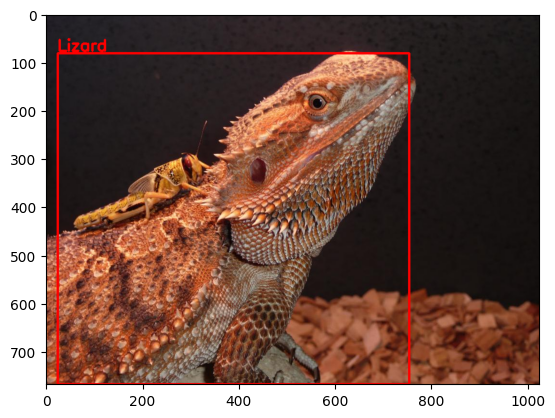

In [41]:
image_file = image_files[45]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))
image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
pl.imshow(image);

In [42]:
yolo_train_dir = "yolo/train"
yolo_test_dir = "yolo/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

yolo/train/images
yolo/train/labels
yolo/test/images
yolo/test/labels


In [43]:
yolo_train_dir = "yolo2/train"
yolo_test_dir = "yolo2/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

yolo2/train/images
yolo2/train/labels
yolo2/test/images
yolo2/test/labels


In [44]:
for subdir_id in tqdm(range(len(all_train_subdir))):
    subdir = all_train_subdir[subdir_id]

100%|██████████| 80/80 [00:00<00:00, 1421797.97it/s]


In [45]:
"%s_%s"%("hawk","xueqin")

'hawk_xueqin'

In [46]:
def process_dataset(subdirs, dst_dir, class_names, size=(640,640), link=False):
    for subdir_id in tqdm(range(len(subdirs))):
        subdir = subdirs[subdir_id]
        prefix=os.path.basename(subdir)
        for image_file in glob.glob(os.path.join(subdir, "*.jpg")):
            image_file_basename=os.path.basename(image_file)
            label_file = os.path.join(subdir, "Label", image_file_basename).replace(".jpg", ".txt")
            dst_image_file = os.path.join(dst_dir, "images/%s_%s"%(prefix,image_file_basename))
            dst_label_file = os.path.join(dst_dir, "labels/%s_%s"%(prefix,image_file_basename.replace(".jpg", ".txt")))
            if os.path.exists(dst_label_file):
                continue

            image = cv2.imread(image_file)
            height, width = image.shape[0:2]
            with open(label_file) as fobj:
                with open(dst_label_file, "w") as wobj:
                    while True:
                        item = fobj.readline()
                        if item is None or len(item)==0:
                            break
                        class_name = prefix
                        item=item[len(class_name):]
                        item = item.split()
                        xmin = float(item[0])
                        ymin = float(item[1])
                        xmax = float(item[2])
                        ymax = float(item[3])

                        cx   = (xmin + xmax)/2.0/width
                        cy   = (ymin + ymax)/2.0/height
                        bw   = (xmax - xmin)/width
                        bh   = (ymax - ymin)/height
                        class_id = class_names.index(class_name)
                        output_line = "%d %f %f %f %f\n"%(class_id, cx, cy, bw, bh)
                        wobj.write(output_line)

            if link==True:
                os.symlink(image_file, dst_image_file)
            else:
                image = cv2.resize(image, size)
                cv2.imwrite(dst_image_file, image)

# process_dataset(all_train_subdir, yolo_train_dir, train_classes, size=(640,640), link=False)
xueqin_train_subdir=all_train_subdir[0:1]
xueqin_classes=[os.path.basename(pp) for pp in xueqin_train_subdir]

process_dataset(xueqin_train_subdir, yolo_train_dir, xueqin_classes, size=(640,640), link=False)

100%|██████████| 1/1 [00:57<00:00, 57.08s/it]


In [47]:
xueqin_test_subdir=all_test_subdir[0:1]
process_dataset(xueqin_test_subdir, yolo_test_dir, xueqin_classes, size=(640,640), link=False)

100%|██████████| 1/1 [00:09<00:00,  9.81s/it]
